In [2]:
import gc
import os
import torch
import json

import numpy as np 
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
# series = pd.Series(network_analytics['OutboundUtilzation (%)'])


In [3]:
train_len = int(len(network_analytics) * 0.80)
valid_len = int(len(network_analytics) * 0.15)

train = network_analytics[:train_len]
valid = network_analytics[train_len:(train_len + valid_len)]
test = network_analytics[train_len + len(valid):]

assert len(network_analytics) == (len(train) + len(valid) + len(test))

print('Proportion of train_set : {:.2f}%'.format(len(train)/len(network_analytics) * 100))
print('Proportion of valid_set : {:.2f}%'.format(len(valid)/len(network_analytics) * 100))
print('Proportion of test_set : {:.2f}%'.format(len(test)/len(network_analytics) * 100))

Proportion of train_set : 80.00%
Proportion of valid_set : 15.00%
Proportion of test_set : 5.01%


In [4]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

raw_seq = [10,20,30,40,50,60,70,80,90]
n_steps = 3
train_x,train_y = split_sequence(train['OutboundUtilzation (%)'].values,n_steps)
valid_x,valid_y = split_sequence(valid['OutboundUtilzation (%)'].values,n_steps)
test_x,test_y = split_sequence(test['OutboundUtilzation (%)'].values,n_steps)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class NetworkAnalyticsDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item, label

In [7]:
class TimeseriesCNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(TimeseriesCNN,self).__init__()
        self.conv1d = nn.Conv1d(3, 64, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [8]:
model = TimeseriesCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [9]:
train = NetworkAnalyticsDataset(train_x.reshape(train_x.shape[0],train_x.shape[1], 1), train_y)
valid = NetworkAnalyticsDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1], 1), valid_y)
test = NetworkAnalyticsDataset(test_x.reshape(test_x.shape[0],test_x.shape[1], 1), test_y)

train_loader = DataLoader(train, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid, batch_size=1, shuffle=False)
test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [14]:
def train(loader : DataLoader):  
    running_loss = .0
    model.train()
    
    for idx, (inputs,labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(loader)
    return train_loss.detach().cpu().numpy()
    
def validate(loader : DataLoader):
    running_loss = .0
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(loader)
        return valid_loss.detach().cpu().numpy()

def test(model, loader : DataLoader):
    running_loss = .0
    model.eval()
    predicted = []
    actuals = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            predicted.extend(preds.detach().cpu().numpy())
            actuals.extend(labels.detach().cpu().numpy())
            
        test_loss = running_loss/len(loader)
        return test_loss.detach().cpu().numpy(), predicted, actuals

In [15]:
def absolute_error_statistics(original : np.array, predicted : np.array):
    assert len(original) == len(predicted)
    return np.absolute(original - predicted)

In [16]:
epochs = 200

train_losses = []
valid_losses = []

for epoch in tqdm(range(epochs)):
    train_losses.append(train(train_loader))
    valid_losses.append(valid(valid_loader))
    gc.collect()
    if epoch % 20 == 0:
      test_error, predicted, actual = test(model, test_loader)
      rest = absolute_error_statistics(np.array(actual), np.array(predicted))
      with open(f'output/epoch_{epoch}.json', 'w') as json_file:
        json.dumps(rest, json_file)
      torch.save(model.state_dict(), f"output/checkpoints/model{epoch}.pt")

with open(f'output/NN_output/train_losses.json', 'w') as json_file:
  json.dumps(train_losses, json_file)

with open(f'output/NN_output/valid_losses.json', 'w') as json_file:
  json.dumps(valid_losses, json_file)


,0
count,1280.000000
mean,6.984262
std,6.910873
min,0.003975
25%,3.133748
50%,5.198843
75%,8.272672
max,52.550213


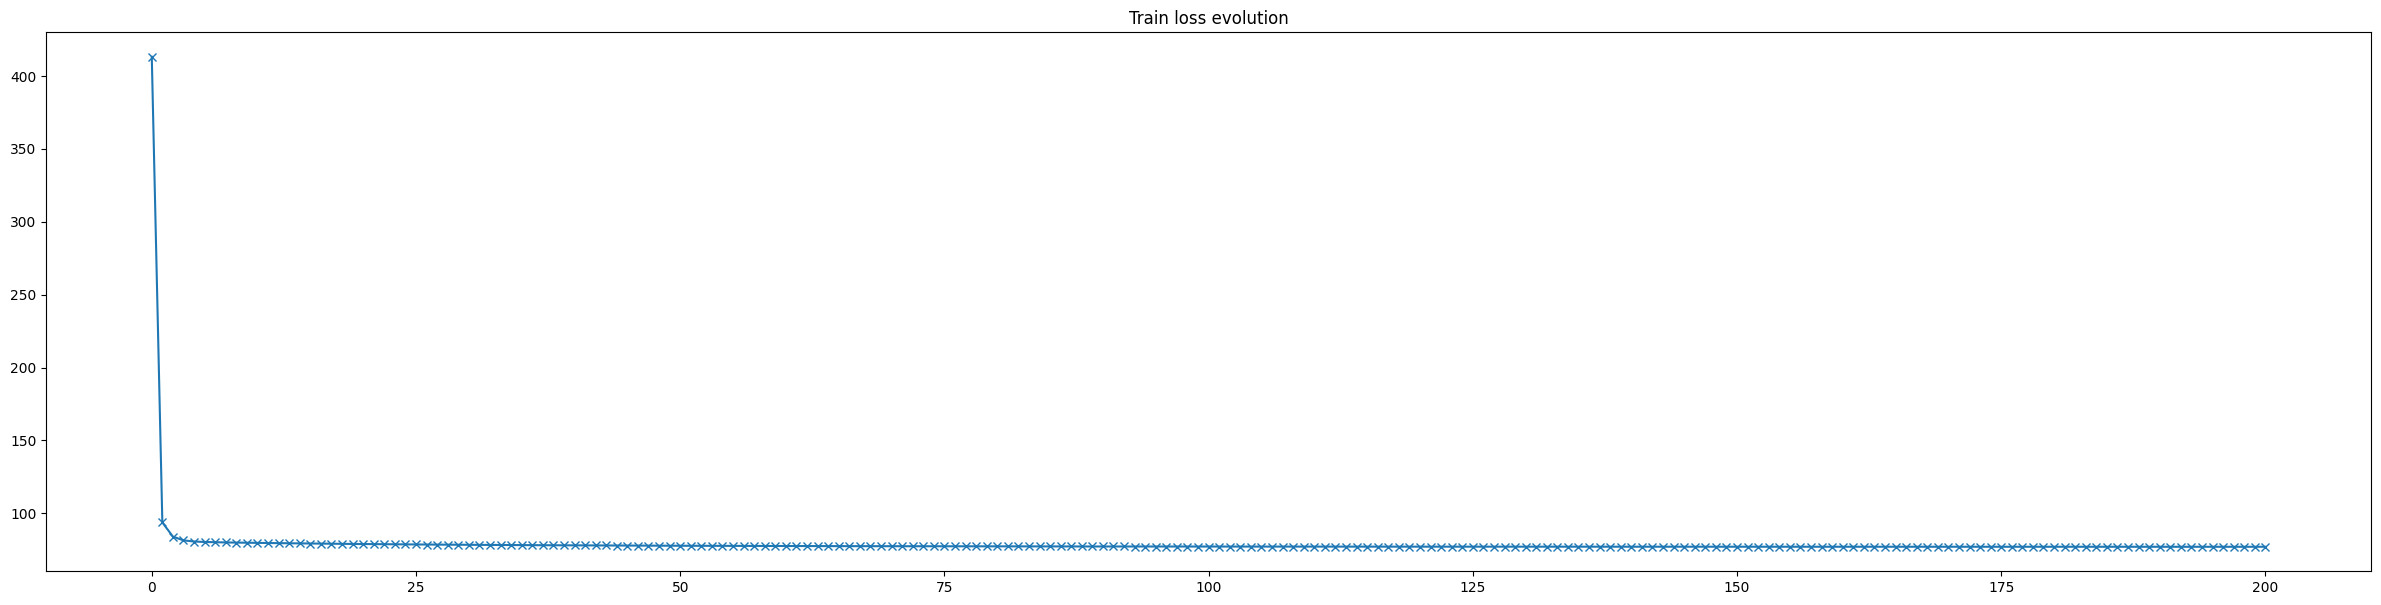

In [7]:
with open(f'output/NN_output/train_losses.json', 'r') as json_file:
    train_losses = json.load(json_file)
    
    plt.figure(figsize=(30,7))
    plt.title('Train loss evolution')
    plt.plot(train_losses, marker='x')
    plt.show()


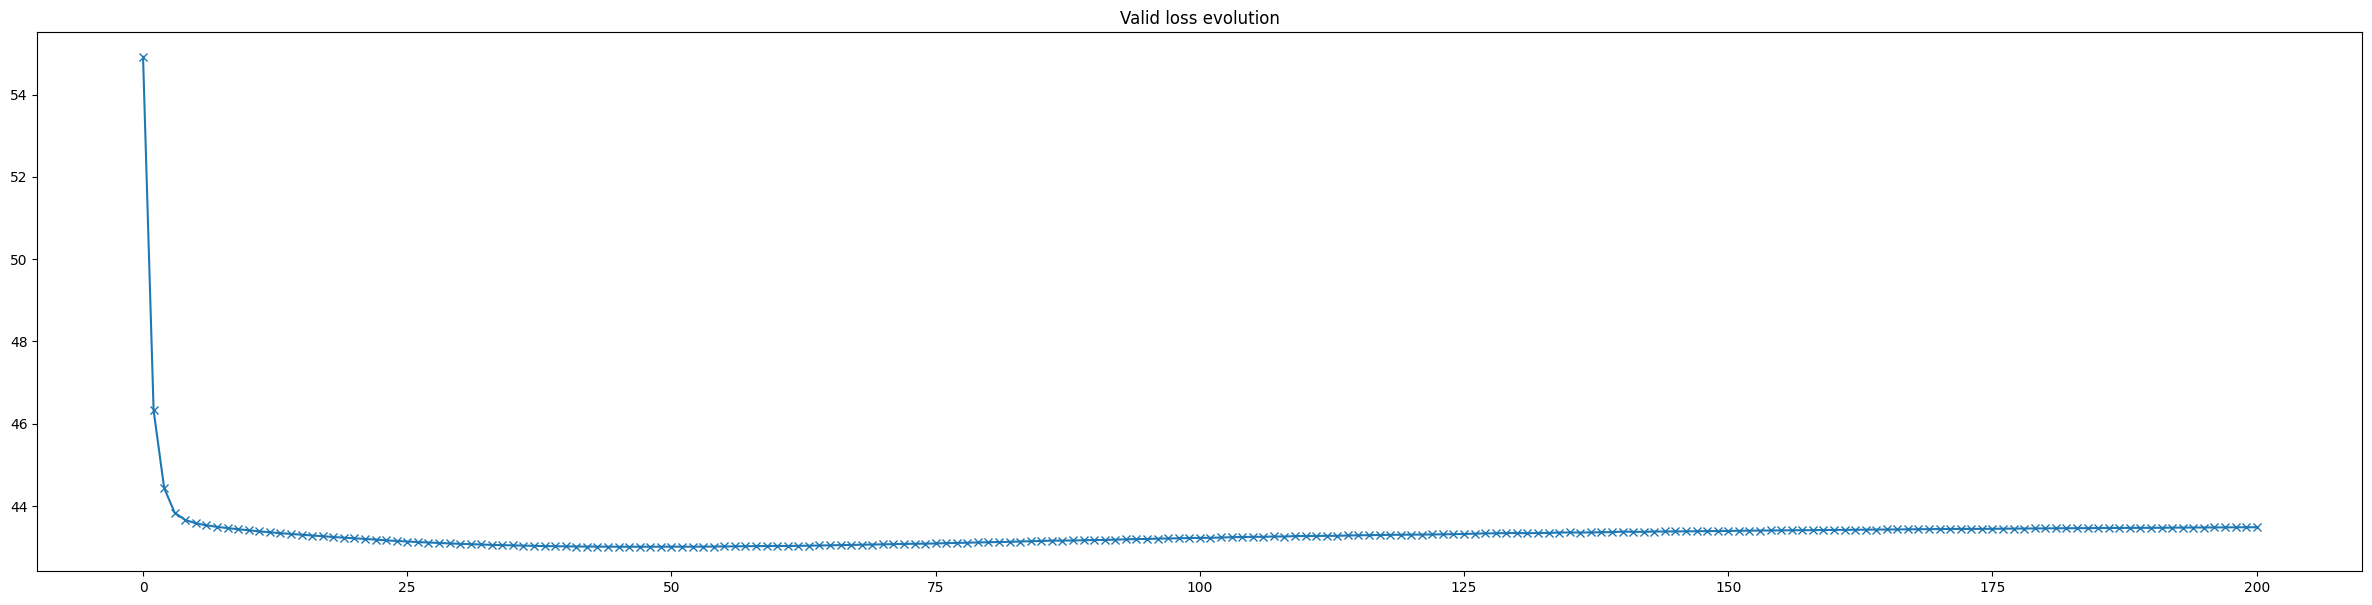

In [8]:
with open(f'output/NN_output/valid_losses.json', 'r') as json_file:
    train_losses = json.load(json_file)
    
    plt.figure(figsize=(30,7))
    plt.title('Valid loss evolution')
    plt.plot(train_losses, marker='x')
    plt.show()

In [ ]:
dataframes = {}

for x in range(0, 201, 20):
    with open(f'output/NN_output/epoch_{x}.json', 'r') as json_file:
        errors = json.load(json_file)
        df = pd.DataFrame(errors).describe()
        dataframes[x] = df

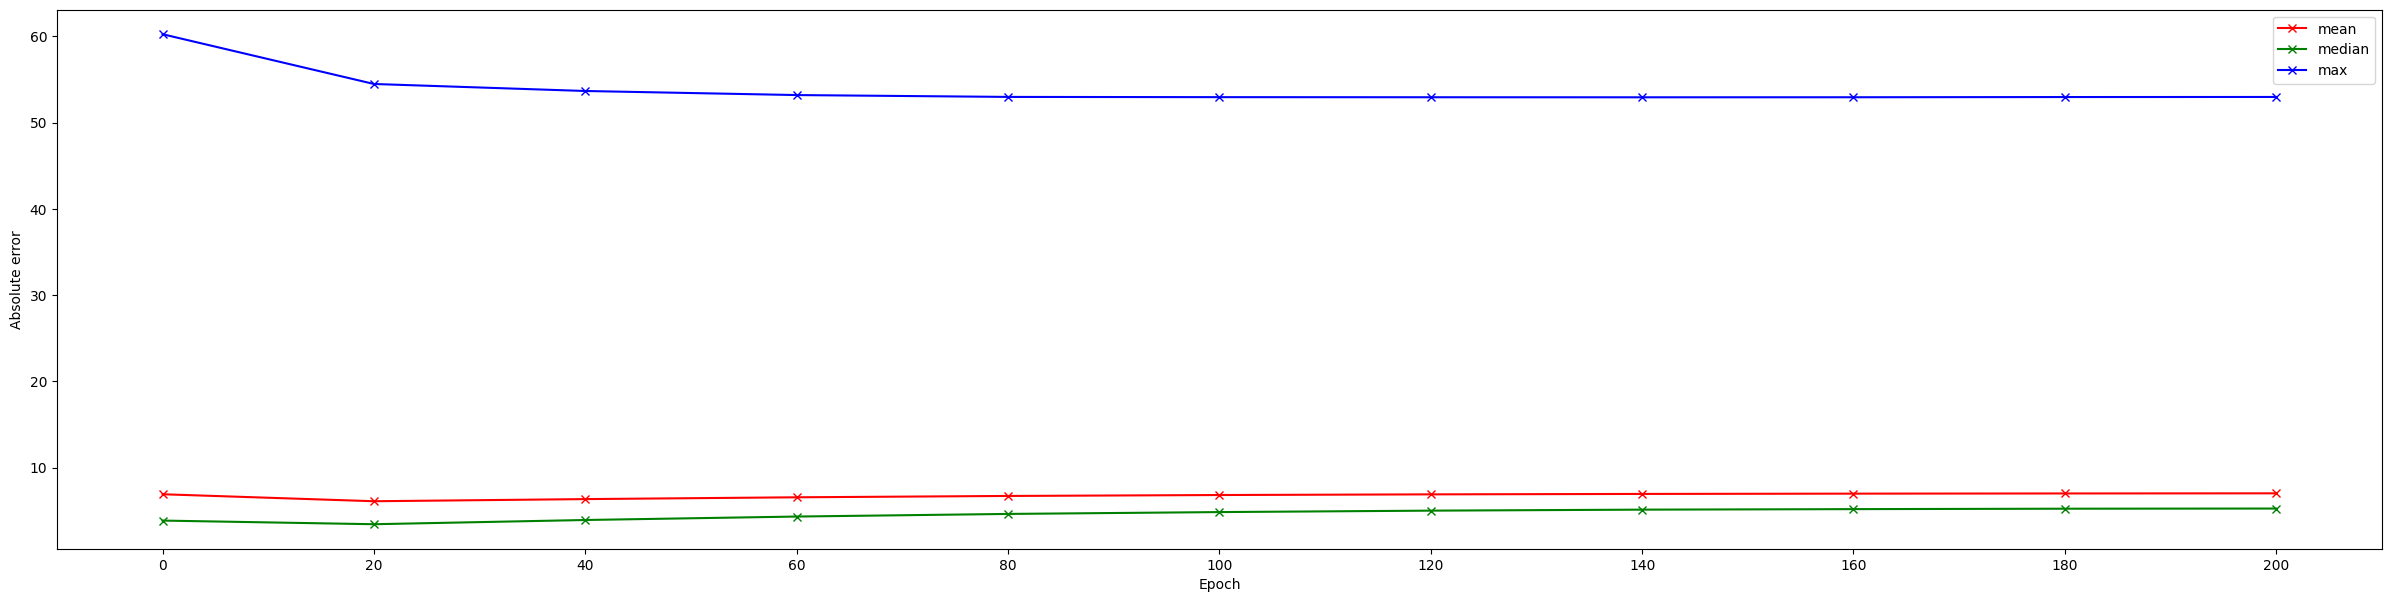

In [20]:
mean = []
fifty = []
max_error = []

for item, value in dataframes.items():
    mean.append(value[0]['mean'])
    fifty.append(value[0]['50%'])
    max_error.append(value[0]['max'])

scale_x = range(0, 201, 20)

plt.figure(figsize=(30,7))
plt.plot(scale_x, mean, color='r', label='mean', marker='x')
plt.plot(scale_x, fifty, color='g', label='median', marker='x')
plt.plot(scale_x, max_error, color='b', label='max', marker='x')
plt.xticks(scale_x)
plt.xlabel('Epoch')
plt.ylabel('Absolute error')
plt.legend(loc='best')
plt.show()